<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/cats_dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 17th Feb, 2021
# My folder: E:/cats_and_dogs/data
# Google drive: /content/drive/MyDrive/Colab_data_files
# Data folder:  '/home/ashok/Images/cats_dogs/
# VM: lubuntu_deeplearning_I
#
# Objectives:
#           i)  Building powerful image classification models using
#               very little data
#           ii) Using image data-augmentation techniques
#           iii)Predicting cats and dogs--Kaggle
#               https://www.kaggle.com/c/dogs-vs-cats
#           iv) Calcualting model weights, stage-by-stage
#            v) Saving model-weights and model-architecture to files
#           vi) Loading saved model-architecture and model-weights

In [ ]:
'''

A. Arrange your data first
==========================

    Download data from: https://www.kaggle.com/c/dogs-vs-cats/data .
    Unzip train.zip and arrange its files as follows:
        data/
            train/
                dogs/                      1000
                    dog001.jpg
                    dog002.jpg
                    ...
                    dog1000.jpg
                cats/                      1000
                    cat001.jpg
                    cat002.jpg
                    ...
                    cat1000.jpg
           validation/
               dogs/                        400
                   dog1001.jpg
                   dog1002.jpg
                   ...
                   dog1400.jpg
              cats/                         400
                  cat1001.jpg
                  cat1002.jpg
                  ...
                  cat1004.jpg

    So we are picking up only 1000 files of each category for training.
    Arrangement of (only) 'training' files in this fashion has an advantage that
    keras automatically knows which images are of cats and which images are
    of dogs. It does automatic labeling of images; we do not have to specify
    explicitly in the code for building training model. This automatic labelling
    is done by ImageGenerator.


In [ ]:
"""
B. Training steps are as follows:
=================================

    1. Arrange training files as above. (Our total samples: nb_train_samples = 2000)
    2. Arrange validation files as above (Valid Samples: nb_validation_samples = 800)
    3. Specify location of all train folder and vaidation folder
    4. Depending upon your backend (tensorflow/theano) decide
       the shape/format of your input image arrays. This is needed in CNN modeling.
    5. Build the CNN model & compile it

    6. Use ImageDataGenerator to augment train images. This is in two steps:
        i)  Create an object with configuration of possible changes in any image
        ii) Use the object to create an iterator with following further configuration:
                a)  Create iterator using flow(), '.flow_from_directory()' method
            In '.flow_from_directory()', specify:
                b)   Where is the directory of your images?
            In ''.flow()' specify X_train, y_train
            Further in both cases:
                b)  Do you also want to resize images, if so, specify these
                c) What batch-size to augment and model at a time;depends upon RAM
                d)  Is classification binary or categorical?

    7. Use ImageDataGenerator to augment validation images. Again the two steps
       as above. But we only resize validation images.
    8. Begin extracting images or training using the iterator fit_generator():
        CNN fit_generator() takes these arguments:
        i)   train-data-iterator (batch-wise source of train images)
        ii)  validation-data generator (batch-wise source of validation images)
        iii) no of epochs


   9. After training has finished, save model weights to a '.h5' file and also
      save model configuration to a json file.


   ------------
   Later, maybe, after some time
   10.Unzip test data file in a folder (within another folder. This is impt.).
   11.Configure test Image Data Generator
   12.Use above configuration and test-folder address, to create a test generator
   13.Load saved cnn model and load network weights in this model from saved h5 file
   14.Use predict() to make predictions on test_generator.
   15.Evaluate predictions

"""

In [ ]:
"""
C. About keras backend:
=======================

    The default keras configuration file is in folder:
        C:\Users\ashokharnal\.keras.  It looks like as below.
        The configurtion is as per the installed backend on your machine:
        tensorflow, theano or CNTK

            {
                    "image_data_format": "channels_last",
                    "epsilon": 1e-07,
                    "floatx": "float32",
                    "backend": "tensorflow"
                    }

            "epsilon" is used instead of zero when division is by zero. 'floatx'
            specifies the datatype that keras will process.
            For 2D data (e.g. image), "channels_last" assumes (rows,cols,channels)
            while "channels_first" assumes (channels,rows,cols)
            (channels stand for RGB colour channels)
"""

In [ ]:
"""
D. Prerequisites:
=================
    Before attempting this problem, pl study Image Augmentation in Moodle at
    http://203.122.28.230/moodle/course/view.php?id=11&sectionid=166#section-9

E. Note
=======
    This is a full code from building model to making predictions for test data.
    AUC is very less as no. of training epochs are just 5. The training consumes
    time but very less memory (around 50%) on an 8GB machine. Vary batch size
    to control memory usage.


F. Make theano as backend
=========================

#    cp /home/ashok/.keras/keras_theano.json  /home/ashok/.keras/keras.json
#    cat /home/ashok/.keras/keras.json
#    source deactivate tensorflow
#    source activate theano
#    ipython
	In file:  ~/.keras/keras.json, set:

	"backend": "theano",    # instead of "tensorflow"

         Also the following environment variable needs to be set in bashrc:

	 export "MKL_THREADING_LAYER=GNU"

'''

In [ ]:
"""

TODO: Use livelossplot
GitHub: https://github.com/stared/livelossplot
SEE example:
https://colab.research.google.com/github/stared/livelossplot/blob/master/examples/keras.ipynb


"""

In [41]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [1]:

#%%                                A. Call libraries

#        $ source activate theano
#        $ ipython
# OR in Windows
#       > conda activate tensorflow_env
#       > atom

# 0. Release memory
%reset -f

# 1.0 Data manipulation library
#     Install in 'tf' environment
#     conda install -c anaconda pandas
import pandas as pd

# 1.1 Call libraries for image processing
#     Another preprocessing option is text and sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.2, Libraries for building sequential CNN model
#      A model is composed of sequence of layered objects
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input

# 1.3.Keras has three backend implementations available: the TensorFlow,
#    the Theano, and CNTK backend.
"""
What is a "backend"?
(http://faroit.com/keras-docs/1.2.0/backend/)
    Keras is a model-level library, providing high-level building blocks
    for developing deep learning models. It does not handle itself low-level
    operations such as tensor products, convolutions and so on. Instead,
    it relies on a specialized, well-optimized tensor manipulation library
    to do so, serving as the "backend engine" of Keras.
    List of low-level functions:
    https://www.tensorflow.org/api_docs/python/tf/keras/backend
"""
from tensorflow.keras import backend as K

# 1.4 Save CNN model configuration
from tensorflow.keras.models import model_from_json

# 1.5 OS related
import os

# 1.6 For ROC plotting
import matplotlib.pyplot as plt

# 1.7
import numpy as np
# conda install scikit-learn
from sklearn import metrics
import time
#from skimage import exposure           # Not used

# 1.8
# conda install -c anaconda pillow
#  Then deactivate and activate environment
#   This step is a must here
from PIL import Image                  # Needed in Windows


In [2]:
# 1.9 Make two folders, one for .tar.gz file
#     and the other for unzipped files
! mkdir /root/catsdogs
! mkdir /root/ashok

In [3]:
# 1.10 Copy tar.gz file from Google drive to Virtual machine
! cp /content/drive/MyDrive/Colab_data_files/cats_dogs.tar.gz  /root/catsdogs

# 1.11 And check
! ls /root/catsdogs

cats_dogs.tar.gz


In [ ]:
# 1.12 Untar file to folder /root/ashok/
! tar -xvf /root/catsdogs/cats_dogs.tar.gz  -C /root/ashok

In [81]:
# 1.13 Check folders under 'ashok'
#      Folder 'cats_dogs' should exist:

! ls /root/ashok/
print("====")

! ls /root/ashok/cats_dogs
print("====")

! ls /root/ashok/cats_dogs/train
print("====")

# ! ls /root/ashok/cats_dogs/train/cats

cats_dogs  model
====
test  train  validation
====
cats  dogs
====


In [28]:
#%%                            B. Define constants

# 2. Our constants
# 2.1 Dimensions to which our images will be adjusted
img_width, img_height = 150, 150

# 2.2 Data folder containing all training images, maybe in folders: cats and dogs
#train_data_dir = '/home/ashok/Images/cats_dogs/train'
#train_data_dir ="C:\\Users\\ashok\\Desktop\\chmod\\2. data_augmentation\\cats_dogs\\train"
train_data_dir = '/root/ashok/cats_dogs/train'
test_data_dir =  '/root/ashok/cats_dogs/test'

# 2.3 What is the total number of training images
#      that should be generated (not what are available)
nb_train_samples = 2000   # Actual: 1000 + 1000 (more) =    2000

# 2.4 Data folder containing all validation images

#validation_data_dir = '/home/ashok/Images/cats_dogs/validation'
#validation_data_dir = "C:\\Users\\ashok\\Desktop\\chmod\\2. data_augmentation\\cats_dogs\\validation"
validation_data_dir = '/root/ashok/cats_dogs/validation'

# 2.5 What is the total no of validation samples that should
#     be generated?
nb_validation_samples = 800   # Actual: 400 + 400 (more) =  800

# Some hyperparameters

# 2.6 Batch size to train at one go:
batch_size = 16             # No of batches = 4000/125 = 32
                            # So per epoch we have 32 batches

# 2.7 How many epochs of training?
epochs = 5                  # For lack of time, let us make it just 5.

# 2.8 No of test samples
test_generator_samples = 300

# 2.9 For test data, what should be batch size
test_batch_size = 25    # This is different from training batch size



In [7]:

# 3. About keras backend
# 3.1 Can get backend configuration values, as:
K.image_data_format()          # Read .keras conf file to findout
K.backend()

# 3.2 What is our backend and input_shape? Decide data shape as per that.
#     Depth goes last in TensorFlow back-end, first in Theano
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:                                         # So, Tensorflow!
    input_shape = (img_width, img_height, 3)


In [8]:
# 4. Create convnet model
#    con->relu->pool->con->relu->pool->con->relu->pool->flatten->fc->fc

#     Call model constructor and then pass on a list of layers
#     https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

model = Sequential()

In [9]:
# 4.1 Add Input layer
model.add(Input(shape =input_shape ))
# 4.2 Add Conv2D layer
model.add(Conv2D(
	             filters=32,                # For every filter there is set of weights
	                                        # For each filter, one bias. So total bias = 32
	             kernel_size=(3, 3),        # For each filter there are 3*3=9 kernel_weights
	             strides = (1,1),           # So output shape will be 148 X 148 (W-F+1).
	                                        # Default strides is 1 only
	             #input_shape=input_shape,   # (150,150,3)
	             use_bias=True,             # Default value is True
	             padding='valid',           # 'valid' => No padding. This is default.
	             name="Ist_conv_layer"
	             )
         )

In [10]:
# 4.3 So what have we done? Can you explain?
#     Total weights = (kernel_weights) * RGB_channel * (filters)  + ToalNoBias
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 4.4 For each neuron in the convolved network,
#     assign an activation function
#     What is relu? See https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

model.add(Activation('relu'))           # max {0,x}

# 4.5
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 4.6 pool_size:  max pooling window size: (2,2)
#     Default stride for pool-layer is same as pool_size
#     Here: 2 across and 2 down ie (2,2)
#     https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
model.add(MaxPool2D(pool_size=(2, 2)))

# 4.7
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 4.8 Input shape is inferred. Default strides is 1.
#     Note: Activation is specified here only
#     input_shape from top = 74 X 74 X 32
model.add(Conv2D(32,
                (3, 3),
                activation = 'relu',
                name = "IInd_con_layer"))

# 4.9 So how many parameters now?
#     Total weights = (kernel_weights) * (filters_from_earlier_conv) * (filters)  + ToalNoBias
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
IInd_con_layer (Conv2D)      (None, 146, 146, 32)      9248      
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [12]:
# model.add(Activation('relu'))

# 4.10 Add another pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))

# 4.11 Summary?
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
IInd_con_layer (Conv2D)      (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 4.12 Add another conv layer but with 64 filters
#      Total weights = (kernel_weights) * (filters_from_earlier_conv) * (filters)  + ToalNoBias

model.add(Conv2D(64, (3, 3), name = "IIIrd_conv_layer"))

# 4.13
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
IInd_con_layer (Conv2D)      (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
IIIrd_conv_layer (Conv2D)    (None, 71, 71, 64)        18496     
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 4.14
model.add(Activation('relu'))

# 4.15
model.add(MaxPool2D(pool_size=(2, 2)))

# 4.16 Flattens the input. Does not affect the batch size.
#      It merely flattens the earlier layer without adding any weight
#     See summary() next
#     https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

model.add(Flatten(name = "FlattenedLayer"))

# 4.17
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
IInd_con_layer (Conv2D)      (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
IIIrd_conv_layer (Conv2D)    (None, 71, 71, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
FlattenedLayer (Flatten)     (None, 78400)             0

In [15]:
# 4.18 Dense layer having 64 units
#      dimensionality of the output space.
#      Total weights = hidden_neurons * input_size + bias_foreach_hidden_neurons
#      64 * 18496 + 64
#      Most number of weights come from this layer
#      https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

model.add(Dense(64))

# 4.19
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
IInd_con_layer (Conv2D)      (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
IIIrd_conv_layer (Conv2D)    (None, 71, 71, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
FlattenedLayer (Flatten)     (None, 78400)             0

In [16]:
# 4.20
model.add(Activation('relu'))

# Dropout
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
model.add(Dropout(0.5))

# 4.21
model.summary()


# 4.22 Dense layer having 1 unit
#      dimensionality of the output space.
#      Weights = No of input neurons + bias (64+1)
model.add(Dense(1))

# 4.23
model.summary()

# 4.24
model.add(Activation('sigmoid'))    # tanh vs sigmoid? See Stackoverflow


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ist_conv_layer (Conv2D)      (None, 148, 148, 32)      896       
_________________________________________________________________
IInd_con_layer (Conv2D)      (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
IIIrd_conv_layer (Conv2D)    (None, 71, 71, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
FlattenedLayer (Flatten)     (None, 78400)             0

In [17]:
# 4.25 Compile model
model.compile(
              loss='binary_crossentropy',  # Metrics to be adopted by convergence-routine
              optimizer='rmsprop',         # Strategy for convergence?
              metrics=['accuracy'])        # Metrics, I am interested in




In [18]:

#%%                            D. Create Data generators


## 5. Image augmentation
# 5.1 Define a preprocessing function
def preprocess(img):
	# Histogram equalization
	# WITHOUT IT RESULTS ARE BETTER
	# http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
    # img_eq = exposure.equalize_hist(img)
    # Do something more with image
    return img


In [19]:
# 5.2 Config1: Augmentation configuration for training samples
#     Instantiate ImageDataGenerator object with requisite configuration
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

tr_dtgen = ImageDataGenerator(
                              rescale=1. / 255,      # Normalize colour intensities in 0-1 range
                              shear_range=0.2,       # Shear varies from 0-0.2
                              zoom_range=0.2,
                              horizontal_flip=True,
                              preprocessing_function=preprocess
                              )

In [20]:

# 5.3 Config2: Create iterator from 'train_datagen'.
#     We use flow() or flow_from_directory() methods to further
#     configure and return an iterator object.
#     See at the end of code: Differences between flow()
#     and flow_from_directory
#     Pl see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

train_generator = tr_dtgen.flow_from_directory(
                                               train_data_dir,       # Data folder of cats & dogs
                                               target_size=(img_width, img_height),  # Resize images
                                               batch_size=batch_size,  # Return images in batches
                                               class_mode='binary'   # Output labels will be 1D binary labels
                                                                     # [[1],[0],[0],[1]]
                                                                     # If 'categorical' output labels will be
                                                                     # 2D OneHotEncoded: [[1,0],[0,1],[0,1],[1,0]]
                                                                     # If 'binary' use 'sigmoid' at output
                                                                     # If 'categorical' use softmax at output

                                                )


Found 2000 images belonging to 2 classes.


In [21]:

# 5.4 Augmentation configuration we will use
#     for validation. Only rescaling of pixels

val_dtgen = ImageDataGenerator(rescale=1. / 255)

In [22]:

# 5.4.1 validation data
validation_generator = val_dtgen.flow_from_directory(
                                                     validation_data_dir,
                                                     target_size=(img_width, img_height),   # Resize images
                                                     batch_size=batch_size,    # batch size to augment at a time
                                                     class_mode='binary'  # Return 1D array of class labels
                                                     )

Found 800 images belonging to 2 classes.


In [ ]:

#%%                           E. Fit model & save CNN network weights


## 6. Model fitting

# 6.1 Manual process of fitting. Get infinite images
#     Can experiment with infinite images. We will
#     generate upto 3200 images
#     https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

start = time.time()   # 6 minutes
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    # 6.1.1
    for x_batch, y_batch in train_generator:

        # 6.1.2 Earlier learnt weights are preserved
        # between batches
        model.fit(x_batch, y_batch)
        batches += 1
        print ("Epoch: {0} , Batches: {1}".format(e,batches))
        # 6.1.3
        if batches > 200:    # 200 * 16 = 3200 images
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

end = time.time()
(end - start)/60


In [76]:
# 6.2 fit_generator() directly pulls data from iterators
#     But number of images cannot exceed those available
#     Ref: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator

start = time.time()
history = model.fit_generator(
                              # First argument is always data generator
                              generator = train_generator,          
                              # How many batches per epoch?
                              # Can be any number as generator loops indefinitely 
                              steps_per_epoch=nb_train_samples // batch_size, 
                              # No of epochs                                               
                              epochs=epochs,  
                              # Get validation data from validation generator                      
                              validation_data=validation_generator, 
                              verbose = 1,                          
                              validation_steps=nb_validation_samples // batch_size
                              )

end = time.time()
(end - start)/60


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
125/125 [==============================] - 130s 1s/step - loss: 0.6311 - accuracy: 0.6780 - val_loss: 0.6072 - val_accuracy: 0.6637
Epoch 2/5
125/125 [==============================] - 130s 1s/step - loss: 0.6202 - accuracy: 0.6830 - val_loss: 0.5618 - val_accuracy: 0.7013
Epoch 3/5
125/125 [==============================] - 130s 1s/step - loss: 0.5893 - accuracy: 0.7045 - val_loss: 0.5681 - val_accuracy: 0.6925
Epoch 4/5
125/125 [==============================] - 130s 1s/step - loss: 0.5739 - accuracy: 0.7095 - val_loss: 0.5602 - val_accuracy: 0.7250
Epoch 5/5
125/125 [==============================] - 130s 1s/step - loss: 0.5520 - accuracy: 0.7170 - val_loss: 0.5830 - val_accuracy: 0.7250


10.841946772734325

In [24]:
# 7.0 Model evaluation

# 7.1 Using generator
#     https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
result = model.evaluate(
                        validation_generator,
                        verbose = 1,
                        steps = 4        # How many batches
                        )


# 7.1.1
result     # ['loss', 'accuracy']

4/4 [==============================] - 1s 215ms/step - loss: 0.5057 - accuracy: 0.7500


[0.5057432651519775, 0.75]

In [ ]:
# 8.0 Make predictions

# 8.1 Using generator
#     https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
pred = model.predict(validation_generator, steps = 2)

# 8.1.1
pred[:5]


In [ ]:
# 8.2 Manually
pred = []
steps = 0
start = time.time()
# 8.2.1
for x_batch, y_batch in validation_generator:
        # 8.2.2
        pred.append(model.predict(x_batch))
        steps += 1
        # 8.2.3
        if steps >= 2:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

end = time.time()
(end - start)/60

# 8.2.4
pred


In [ ]:
#### End of class

In [29]:
# 9.0 Augmentation configuration we will use
#     for test-data. Only rescaling of pixels

test_dtgen = ImageDataGenerator(rescale=1. / 255)

# 9.0.1 Test data

test_generator = test_dtgen.flow_from_directory(
                                                test_data_dir,
                                                # Resize images
                                                target_size=(img_width, img_height),   
                                                # batch size to augment at a time
                                                batch_size=batch_size,
                                                # Return 1D array of class labels    
                                                class_mode='binary'  
                                                )

Found 300 images belonging to 1 classes.


In [33]:
# 9.0.2 Get iterator 
#       and a batch of (images, image_labels)
im = test_generator    # Get iterator
images = next(im)      # Get images
images[0].shape

(16, 150, 150, 3)

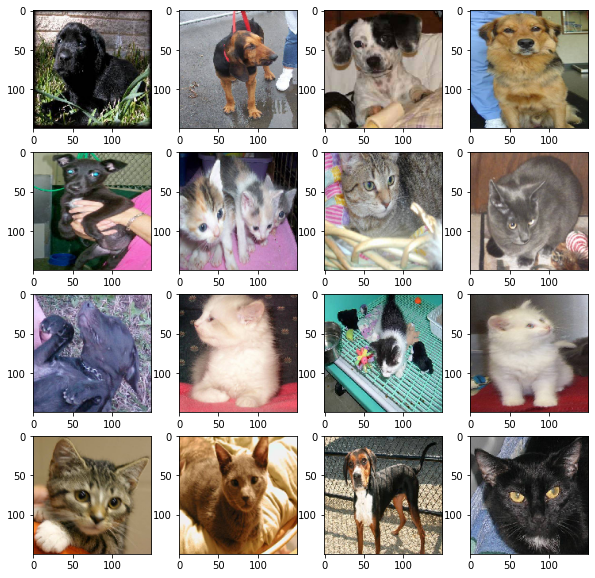

In [44]:
# 9.1 Make predictions
results = model.predict(images[0])

# 9.2 Plot the images and check with
#     results
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.figure(figsize= (10,10))
for i in range(results.shape[0]):
    plt.subplot(4,4,i+1)
    _=imshow(images[0][i]) ;

plt.show() ;
# 9.3 Predicted labels
print(results)         # Probability values
                       # > 0.5 is Dog

### Model saving

In [ ]:
## 10. Model saving
# 10.1 Install h5py using Anaconda
# 10.2 Save CNN model weights to a file
#     The h5py package is a Pythonic interface to HDF5 binary data format.
#     It lets you store huge amounts of numerical data, and easily manipulate
#     that data from NumPy. For example, you can slice into multi-terabyte
#     datasets stored on disk, as if they were real NumPy arrays.
#     Thousands of datasets can be stored in a single file, categorized and
#     tagged however you want.

# 10.3 Delete earlier model folder if it exists
# os.system('rm -rf  /root/ashok/model')
! rm -rf  /root/ashok/model

# 10.4 Create a fresh folder:
# os.mkdir("/home/ashok/useless")
! mkdir -p /root/ashok/model

# 10.5 Check for 'model' folder
! ls -la /root/ashok

In [65]:
# 11.0 Save model weights
model.save_weights("/root/ashok/model/model_cats_dogs.h5")

# 11.1 Check the model-file and its size
! ls  -la /root/ashok/model

total 19748
drwxr-xr-x 2 root root     4096 Feb 17 07:14 .
drwxr-xr-x 4 root root     4096 Feb 17 07:13 ..
-rw-r--r-- 1 root root 20212472 Feb 17 07:14 model_cats_dogs.h5


In [67]:
# 11.2 Copy saved file to your Google drive
! cp -r /root/ashok/model   /content/drive/MyDrive/Colab_data_files/

# 11.2.1 Check for file transfer to google drive
! ls /content/drive/MyDrive/Colab_data_files/model

In [70]:
# 11.3 Save your CNN model structure to 
#      a file in 'json' format: cnn_model.json
cnn_model = model.to_json()
cnn_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}}, {"class_name": "Conv2D", "config": {"name": "Ist_conv_layer", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "IInd_con_layer", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channel

In [ ]:
# 11.4 Now save this json formatted data to a file on hard-disk
#     File name: cnn_model.json. File path: check with setwd()
# 11.4.1. Open/create file in write mode

#json_file = open("/home/ashok/useless/cnn_model.json", "w")
#json_file = open("c:\\users\\ashok\\useless\\cnn_model.json", "w")
json_file = open("/root/ashok/model/cnn_model.json", "w")

# 11.4.2 Write to file
json_file.write(cnn_model)
# 11.4.3 Close file
json_file.close()

# 11.5 Check for saved file
! ls -la /root/ashok/model

In [75]:
#%%                          F. Load model and model weights


## 12. Later

# 12.1 Open saved model file in read only mode
#     Just
# os.chdir("C:\\Users\\ashokharnal")

#json_file = open('/home/ashok/useless/cnn_model.json', 'r')
#json_file = open("c:\\users\\ashok\\useless\\cnn_model.json", "r")
json_file = open('/root/ashok/model/cnn_model.json', 'r')

loaded_model_json = json_file.read()
loaded_model_json            # Model structure in file: loded_model_json
json_file.close()

# 12.2 Create CNN model from the file: loaded_model_json
cnn_model = model_from_json(loaded_model_json)


# 12.3 load saved weights into new model
cnn_model.load_weights("/root/ashok/model/model_cats_dogs.h5")
#cnn_model.load_weights("c:\\users\\ashok\\useless\\first_try.h5")


# 12.4 Compile the model. Same way as was done earlier
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])


#%%                         G. Make predictions on test data

# 13 Where is the directory which contains ANOTHER directory
#   containing your test images
#test_data_dir = validation_data_dir = 'E:/cats_and_dogs/test'


# 13.1 Augmentation configuration for test dataset.
#     Only rescaling as we did for validation data
test_datagen = ImageDataGenerator(rescale=1. / 255)


# 13.2 Create test data generator
test_generator = test_datagen.flow_from_directory(
        test_data_dir,                         # Which folder has test data
        target_size=(img_width, img_height),   # Resize images
        batch_size = test_batch_size,            # batch size to augment at a time
        class_mode=None)                       # Data has binary classes



# 14. Make predictions from loaded model. Takes few seconds.
start = time.time()
predictions = cnn_model.predict_generator(
        test_generator,
        steps= int(test_generator_samples/float(test_batch_size)), # all samples once
        verbose =1
        )
end  = time.time()
(end-start)/60

# 14.1 OR predictions directly from created model
start = time.time()
predictions1 = model.predict_generator(
        test_generator,
        steps=int(test_generator_samples/float(test_batch_size)), # all samples once
        verbose =1
        )

end  = time.time()
(end-start)/60


# 14.2 See arrays of predictions
#predictions
predictions[0:10]


'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}}, {"class_name": "Conv2D", "config": {"name": "Ist_conv_layer", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "IInd_con_layer", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channel

Found 300 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


12/12 [==============================] - 4s 329ms/step


0.06982743342717489

12/12 [==============================] - 4s 326ms/step


0.06826024850209554

array([[0.58160007],
       [0.38266277],
       [0.36412302],
       [0.6478276 ],
       [0.25145355],
       [0.09769836],
       [0.3199457 ],
       [0.8168301 ],
       [0.9948644 ],
       [0.6988313 ]], dtype=float32)

In [ ]:
####--
#### Code to be corrected
####--
#%%                         H. Make submissions on Kaggle


# 15. Unfortunately Kaggle is not allowing submissions.
#     I have manually compiled a file looking at 300 images out of 12500
#     images in the test folder.
actual=pd.read_csv("E:/cats_and_dogs/actual_result300.csv", header = 0)
actual.head()

# 15.1 Add predictions column to this data frame
actual['new'] = predictions[0:300]

# 15. Evaluate accuracy
fpr, tpr, _ = metrics.roc_curve(actual['label'], actual['new'])

# 15.1 AUC
metrics.roc_auc_score(actual['label'], actual['new'])

# 15.2 ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.show()

############ END ##############################################